## [Multi-Scale Energy (MuSE) Framework for Inverse Problems in Imaging](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10645311)
Jyothi Rikhab Chand, Mathews Jacob

# Goal of this notebook:

To use the pre-trained energy model for reconstructing images from the undersampled k-space data

In [26]:
# Preliminaries
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

#Load dataset
from data_builder import DataGenBrain

#Load save model script
from saveModels import saveHelper

#Load energy model script
from energy_model import *
from network_unet import UNetRes



# To import the accelerated MM algorithm
from utils import MM
#To import the MRI forward operator
from sense_new import sense_v1




torch.cuda.empty_cache()

## Load Test Settings

In [2]:
import json
gpu = torch.device('cuda')
load_test_setting = open("settings.json")
ts=json.load(load_test_setting)
beta = ts["beta"]
L = ts["L"]
inference_std = ts["inference_std"]
threshold = ts["threshold"]
max_iter = ts["max_iter"]
const = 2*(inference_std**2)
A = sense_v1(10)


## Load Dataset

In [3]:
data_set=DataGenBrain(start_sub = ts["startSubj"], num_sub = ts["endSubj"],device = device, acc = ts["acc"])

T2_big_pickle - loading 1 of 1 subjects
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
Loaded dataset of 10 slices



## Load pre-trained energy model

In [4]:
net = UNetRes(in_nc=ts["input_channel"], out_nc = ts["output_channel"],nc = [ts["ch0"],ts["ch1"], ts["ch2"], ts["ch3"]])
net = net.to(device)
energy_net = EBM(net)
fname = "Models/"
energy_net.load_state_dict(torch.load(fname+"/models/net100.pt"))
energy_net.eval()

EBM(
  (net): UNetRes(
    (m_head): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (m_down1): Sequential(
      (0): ResBlock(
        (res): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (1): ResBlock(
        (res): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (2): ResBlock(
        (res): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
 

## Inference on the example data

In [5]:
total_sl = [10]

prediction_MuSE = np.zeros([10,320,320],dtype=np.float32)
prediction_sense = np.zeros([10,320,320],dtype=np.float32)
target = np.zeros([10,320,320],dtype=np.float32)


psnri_MuSE = np.zeros(total_sl,)
psnri_sense = np.zeros(total_sl,)

ssimi_MuSE = np.zeros(total_sl,)
ssimi_sense = np.zeros(total_sl,)







for slc in range(len(data_set)):
    tstOrg,b,tstCsm,tstMask,idx = data_set[slc]
    tstOrg = tstOrg.type(torch.complex64)
    tstOrg = tstOrg.to(device) 
    Atb = A.adjoint(b, tstCsm)
    x_tilde = A.sense_sol(Atb,Atb,100,tstCsm,tstMask)
    x_init = x_tilde
    x_mm = MM(x_init, energy_net,A,b,tstOrg,tstCsm,tstMask,Atb,inference_std,1,L,beta,max_iter,threshold)
    
    prediction_MuSE[slc] = np.squeeze(torch.abs(x_mm).detach().cpu().numpy())
    prediction_sense[slc] = np.squeeze(torch.abs(x_tilde).detach().cpu().numpy())
    target[slc] = np.squeeze(torch.abs(tstOrg).detach().cpu().numpy())
    psnri_MuSE[slc] = peak_signal_noise_ratio(target[slc], prediction_MuSE[slc], data_range=target[slc].max()) 
    ssimi_MuSE[slc] = structural_similarity(target[slc], prediction_MuSE[slc])
    psnri_sense[slc] = peak_signal_noise_ratio(target[slc], prediction_sense[slc], data_range=target[slc].max()) 
    ssimi_sense[slc] = structural_similarity(target[slc], prediction_sense[slc])
    


## Computating Avg. PSNR (dB) & SSIM

In [6]:
avg_psnr_MuSE = np.mean(psnri_MuSE)
avg_ssim_MuSE = np.mean(ssimi_MuSE)
avg_psnr_sense = np.mean(psnri_sense)
avg_ssim_sense = np.mean(ssimi_sense)
print(f'Avg PSNR (MuSE): {avg_psnr_MuSE:.3f} dB')
print(f'Avg PSNR (SENSE): {avg_psnr_sense:.3f} dB')
print(f'Avg SSIM (MuSE): {avg_ssim_MuSE:.3f}')
print(f'Avg SSIM (SENSE): {avg_ssim_sense:.3f}')

Avg PSNR (MuSE): 38.569 dB
Avg PSNR (SENSE): 36.096 dB
Avg SSIM (MuSE): 0.982
Avg SSIM (SENSE): 0.962


## Display Reconstructions

(-0.5, 319.5, 319.5, -0.5)

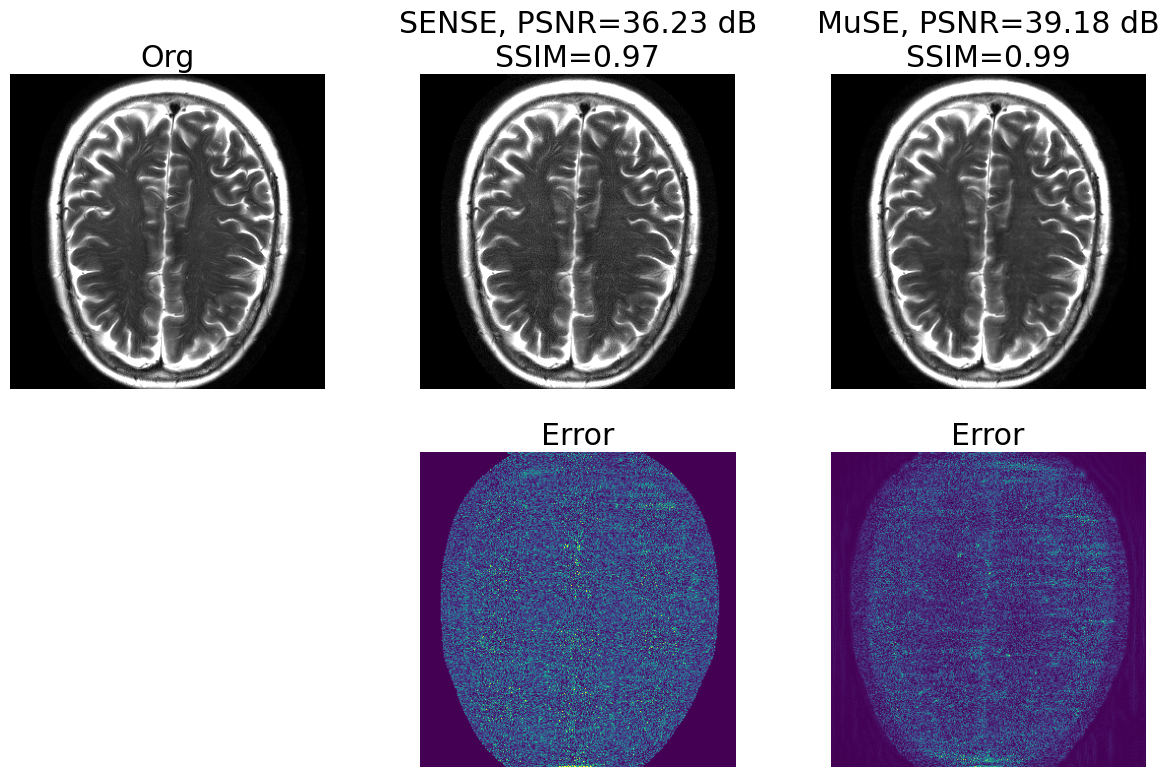

In [25]:
plt.rcParams.update({'font.size': 18})
index = 7
error_imgs_MuSE= np.abs(target[index] - prediction_MuSE[index])
error_imgs_sense= np.abs(target[index] - prediction_sense[index])

plt.figure(figsize=(15,9))
plt.subplot(231)
plt.imshow(target[index],plt.cm.gray,vmax=0.5)
plt.title('Org')
plt.axis('off')

plt.subplot(232)
plt.imshow(prediction_sense[index],plt.cm.gray,vmax=0.5)
plt.title(f'SENSE, PSNR={psnri_sense[index]:.2f} dB\nSSIM={ssimi_sense[index]:.2f}')
plt.axis('off')

plt.subplot(233)
plt.imshow(prediction_MuSE[index],plt.cm.gray,vmax=0.5)
plt.title(f'MuSE, PSNR={psnri_MuSE[index]:.2f} dB\nSSIM={ssimi_MuSE[index]:.2f}')
plt.axis('off')

plt.subplot(235)
plt.imshow(error_imgs_sense,vmax=0.05)
plt.title('Error')
plt.axis('off')

plt.subplot(236)
plt.imshow(error_imgs_MuSE,vmax=0.05)
plt.title('Error')
plt.axis('off')